In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
import hdbscan
import os
import json

import sys
sys.path.append('..')
sys.path.append('../autoencoder')


from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

from src.band_plotters import *
from src.Tiff32Image import Tiff32Image, load_tiff_uint32_image

In [2]:
FINGERPRINT_NAME = "max_bands_encoder"
    
FINGERPRINT_LENGTH = 3584
PERPLEXITY = 50
OUTPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"
print(FINGERPRINT_NAME)

max_bands_encoder


To make a new finerprint all you need to change is the constants above and/or the calc_fingerprint function below.
# All K Branches Histogram Fingerprint
Bin all energy values between -8 and +8 eV for each branch in K space.

## Start with Anupam's list of materials

In [3]:
df_material = pd.read_csv("../fingerprints/template.csv", index_col="ID")
df_material.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,C,D,E,F,radio,f_orb,sg_sto_group,percentage_flat,relative_id,crystal_system
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4963,trigonal
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3279,trigonal
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,276.0,24.2,2dm-5155,triclinic
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-4342,trigonal
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,NaN,NaN,NaN,NaN,non-radioactive,no-f-in-valence,NaN,NaN,2dm-3574,trigonal


## Fingerprint Functions Here
Fingerprint functions take material ID as only input

In [4]:
def run_trained_model_one_mat(material_id, CNN_model, input_band_image_type, data_directory=DATA_DIRECTORY):
        image_filename = data_directory/f"images/energies{input_band_image_type}/{material_id}.tiff"
        input_tensor = torch.from_numpy(load_tiff_uint32_image(image_filename).astype(np.float64))
        input_tensor = input_tensor / (2**16-1)
        input_tensor = input_tensor[None, None, :, :]

        input_tensor = input_tensor.float().cpu()
        output_tensor = CNN_model.encode.forward(input_tensor)
        
        # flatten encoded 2d array representation of the band structure as the fingerprint
        return output_tensor.flatten().detach().numpy()
        
# change path to the location of the desired trained model
model_path = "../autoencoder/trained_models/simple_ae_1.pkl"
# name of the energy{name} folder which holds the input band tensors
CNN_input_file_index = 8
# load the model that we have already trained on the data
trained_model = load_learner(model_path)

fingerprint = run_trained_model_one_mat("2dm-11", trained_model, CNN_input_file_index)
print(fingerprint)

NotImplementedError: cannot instantiate 'PosixPath' on your system

In [34]:
def calc_all_k_branches_histogram_fingerprint(material_id, fingerprint_length=FINGERPRINT_LENGTH, e_range=None, normalize=False, shifted=True):
    filename_bands=DATA_DIRECTORY/f"bands/{material_id}.json"
    if not filename_bands.exists():
        print(f"No such file {filename_bands}")
        
    bands_dict=json.load(open(filename_bands))

    fingerprint = np.zeros(fingerprint_length)
    
    k_branches = bands_dict["branches"]
    length_per_branch = fingerprint_length // len(k_branches)

    energies = np.array(bands_dict["bands"]["1"])

    if shifted:
        energies -= bands_dict["efermi"]

    for i, branch in enumerate(k_branches):
        branch_energies = energies[:, branch["start_index"]:branch["end_index"]+1]

        counts, edges = np.histogram(branch_energies, bins=length_per_branch, range=e_range, density=normalize)

        fingerprint[i*length_per_branch : (i+1)*length_per_branch] = counts
    
    return fingerprint

In [9]:
fingerprint_functions = {
    "all_k_branches_histogram_-8_to_8": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=False),
    "all_k_branches_histogram_all_energies": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=False),
    "all_k_branches_histogram_-8_to_8_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, e_range=[-8, 8], normalize=True),
    "all_k_branches_histogram_all_energies_normed": lambda x: calc_all_k_branches_histogram_fingerprint(x, normalize=True),
    "max_bands_encoder": lambda x: run_trained_model_one_mat(x, CNN_model=trained_model, input_band_image_type=CNN_input_file_index)
}

for fingerprint_name in fingerprint_functions: 
    fp = fingerprint_functions[fingerprint_name]("2dm-1")
    plt.plot(fp)
    plt.title(fingerprint_name)
    plt.show()
    

NameError: name 'calc_all_k_branches_histogram_fingerprint' is not defined

In [40]:
fingerprint_array = np.zeros([len(df_material), FINGERPRINT_LENGTH])

In [41]:
for i, material_id in enumerate(df_material.index):
    if i % 100 == 0:
        print(i, "/", len(df_material))

    fingerprint_array[i, :] = fingerprint_functions[FINGERPRINT_NAME](material_id)

print(fingerprint_array)

0 / 5270
100 / 5270
200 / 5270
300 / 5270
400 / 5270
500 / 5270
600 / 5270
700 / 5270
800 / 5270
900 / 5270
1000 / 5270
1100 / 5270
1200 / 5270
1300 / 5270
1400 / 5270
1500 / 5270
1600 / 5270
1700 / 5270
1800 / 5270
1900 / 5270
2000 / 5270
2100 / 5270
2200 / 5270
2300 / 5270
2400 / 5270
2500 / 5270
2600 / 5270
2700 / 5270
2800 / 5270
2900 / 5270
3000 / 5270
3100 / 5270
3200 / 5270
3300 / 5270
3400 / 5270
3500 / 5270
3600 / 5270
3700 / 5270
3800 / 5270
3900 / 5270
4000 / 5270
4100 / 5270
4200 / 5270
4300 / 5270
4400 / 5270
4500 / 5270
4600 / 5270
4700 / 5270
4800 / 5270
4900 / 5270
5000 / 5270
5100 / 5270
5200 / 5270
[[0.01527608 0.03450027 0.02956857 ... 0.         0.         0.        ]
 [0.01542905 0.01676923 0.01689559 ... 0.         0.         0.        ]
 [0.01604144 0.02051008 0.02053594 ... 0.         0.         0.        ]
 ...
 [0.0151739  0.02795745 0.02718203 ... 0.         0.         0.        ]
 [0.01589932 0.02253973 0.02244416 ... 0.         0.         0.        ]
 [0.01

In [42]:
#check for NaNs 
np.isnan(fingerprint_array).sum()

0

## Create T-SNE Reduced Dimension Fingerprints

In [47]:
tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate=100, random_state=0, perplexity=PERPLEXITY ,n_iter=10000, verbose=2)
fingerprint_2d = tsne.fit_transform(fingerprint_array)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5270 samples in 0.017s...
[t-SNE] Computed neighbors for 5270 samples in 2.581s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5270
[t-SNE] Computed conditional probabilities for sample 2000 / 5270
[t-SNE] Computed conditional probabilities for sample 3000 / 5270
[t-SNE] Computed conditional probabilities for sample 4000 / 5270
[t-SNE] Computed conditional probabilities for sample 5000 / 5270
[t-SNE] Computed conditional probabilities for sample 5270 / 5270
[t-SNE] Mean sigma: 0.043212
[t-SNE] Computed conditional probabilities in 0.361s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 74.8266296, gradient norm = 0.0001165 (50 iterations in 2.510s)
[t-SNE] Iteration 100: error = 74.7971954, gradient norm = 0.0000360 (50 iterations in 2.491s)
[t-SNE] Iteration 150: error = 74.7970123, gradient norm = 0.0000325 (50 iterations in 2.420s)
[t-SNE] Iteration 200: error = 74.7970123, gradient norm = 0.0000322 (50 iterations in 2.372s)
[t-SNE] Iteration 250: error = 74.7968903, gradient norm = 0.0000302 (50 iterations in 2.435s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.796890
[t-SNE] Iteration 300: error = 2.0691922, gradient norm = 0.0015058 (50 iterations in 2.558s)
[t-SNE] Iteration 350: error = 1.7118459, gradient norm = 0.0006486 (50 iterations in 2.094s)
[t-SNE] Iteration 400: error = 1.5571244, gradient norm = 0.0003852 (50 iterations in 2.137s)
[t-SNE] Iteration 450: error = 1.4715285, gradient norm = 0.0002543 (50 iterations in 1.730s)
[t-SNE] Iteration 500: error = 1.4173752, gradient norm = 0.0001814 (50 

## Quick cluster (not saved) and plots to check fingerprint and T-SNE worked

In [44]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=3, p=0.2)
clusterer.fit(fingerprint_array)
labels = clusterer.labels_

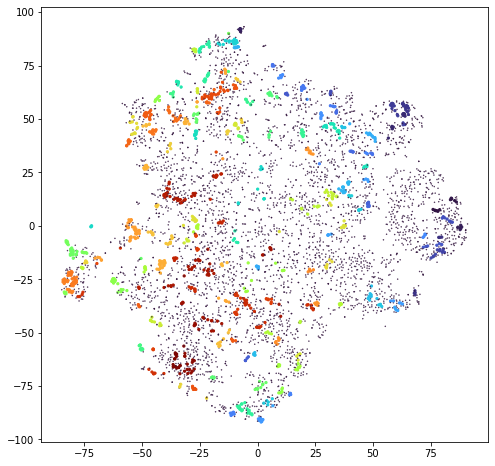

In [48]:
fig, ax  = plt.subplots(figsize=(8,8))
size=np.ones((len(labels),1))*5
size[labels==-1]=0.2

ax.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")

## Add fingerprints, T-SNE to dataframe

In [49]:
df = df_material.join(pd.DataFrame(fingerprint_array, index=df_material.index))
df["fx"] = fingerprint_2d[:, 0]
df["fy"] = fingerprint_2d[:, 1]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,3576,3577,3578,3579,3580,3581,3582,3583,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-1,IrF2,AB2,164,3,0,0.095102,bottom-up,0,0,0.234620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.080276,10.543071
2dm-2,Ba2Sb,AB2,164,3,1,0.387410,bottom-up,0,0,0.210650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-79.903282,-13.024994
2dm-3,TlS,AB,2,4,4,0.846460,bottom-up,1,3,0.095794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.469423,50.144436
2dm-4,MoCl2,AB2,166,5,4,0.713760,bottom-up,0,0,-0.055818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.967300,10.198883
2dm-6,RuI2,AB2,164,3,1,0.264930,bottom-up,0,0,0.084831,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-37.593678,36.069912


In [50]:
df.to_csv("../fingerprints/"+OUTPUT_NAME)

# View a predicted band 

In [4]:

from models import *
view_prediction("2dm-1979", trained_model)

NameError: name 'trained_model' is not defined